Лабораторная работа 4. Кластеризация

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Задачи:

1. Загрузить датасет для задачи кластеризации. Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы), провести анализ выбросов.

2. Выполнить стандартизацию/нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных и предположительного количества кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя или анализа силуэта.

4. Рассчитать метрики качества для обоих методов. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Провести сравнительный анализ решений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости), визуализировать диаграмму рассеивания с выделенными кластерами. Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные разными методами.

Выбранный датасет: Stellar Classification Dataset: Классификация звёзд, галактик и квазаров. <br> <br>
Описание датасета: данные состоят из 100000 наблюдений за космосом, сделанных в рамках проекта SDSS (Sloan Digital Sky Survey). Каждое наблюдение описывается 17 столбцами с характеристиками и 1 столбцом с классом, который определяет, является ли объект звездой, галактикой или квазаром.

Столбцы в датасете: <br>
obj_ID = идентификатор объекта, уникальное значение, которое идентифицирует объект в каталоге изображений, используемом CAS <br>
alpha = угол прямого восхождения (в эпоху J2000) <br>
delta = угол склонения (в эпоху J2000) <br>
u = ультрафиолетовый фильтр в фотометрической системе <br>
g = зелёный фильтр в фотометрической системе<br>
r = красный фильтр в фотометрической системе<br>
i = фильтр ближнего инфракрасного диапазона в фотометрической системе<br>
z = инфракрасный фильтр в фотометрической системе<br>
run_ID = номер запуска, используемый для идентификации конкретного сканирования<br>
rereun_ID = номер повторного запуска, указывающий на способ обработки изображения<br>
cam_col = столбец камеры для определения строки сканирования в прогоне<br>
field_ID = номер поля для идентификации каждого поля<br>
spec_obj_ID = уникальный идентификатор, используемый для оптических спектроскопических объектов<br>
**class** = **целевая переменная**, объект класса (галактика, звезда или квазар)<br>
redshift = значение красного смещения, основанное на увеличении длины волны<br>
plate = идентификатор пластины, уникальный для каждой пластины в SDSS<br>
MJD = модифицированная юлианская дата, используемая для обозначения времени получения данных SDSS<br>
fiber_ID = идентификатор волокна, который определяет волокно, направляющее свет в фокальную плоскость при каждом наблюдении<br>

1. Загрузка данных <br>

В исходном датасете 100000 значений, для анализа было взято 15000 случайно выбранных значений.

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances


df = pd.read_csv('star_classification.csv')
df = df.replace('?', pd.NA).dropna()

columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 
                   'field_ID', 'spec_obj_ID', 'fiber_ID',
                   'plate', 'MJD', 
                   'cam_col', 'class']
df = df.drop(columns=columns_to_drop)

df_sampled = df.sample(n=15000, random_state=42).reset_index(drop=True)
df = df_sampled

print(f"Размер: {df.shape}")
print(df.describe())


Размер: (15000, 8)
              alpha         delta             u             g             r  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean     178.089717     24.095424     22.064910     20.629557     19.642072   
std       96.896533     19.602280      2.238221      2.037240      1.852791   
min        0.013337    -17.284791     12.262400     10.511390     10.068540   
25%      126.903092      4.961883     20.331623     18.972953     18.134835   
50%      181.424085     23.635732     22.173555     21.101795     20.124185   
75%      234.193879     39.863946     23.656040     22.121208     21.037782   
max      359.999810     82.947622     29.234380     27.264660     27.397090   

                  i             z      redshift  
count  15000.000000  15000.000000  15000.000000  
mean      19.086250     18.766182      0.573173  
std        1.759896      1.763420      0.726217  
min       11.263940     10.225510     -0.004255  
25%       17.727735

2. Подсчёт значений ассиметрии, эксцесса и моды

In [133]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("Асимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")

Асимметрия:
alpha               :   -0.019
delta               :    0.179
u                   :   -0.077
g                   :   -0.430
r                   :   -0.519
i                   :   -0.395
z                   :   -0.279
redshift            :    2.489

Эксцесс:
alpha               :   -0.559
delta               :   -1.047
u                   :   -0.513
g                   :   -0.368
r                   :   -0.361
i                   :   -0.234
z                   :   -0.261
redshift            :    9.719

Мода:
alpha               : 0.0133366618319997
delta               : -17.2847913705915
u                   : 24.63465
g                   : 16.82076
r                   : 17.30397
i                   : 18.30478
z                   : 22.8269
redshift            : 0.0


3. Построение гистограмм распределений признаков

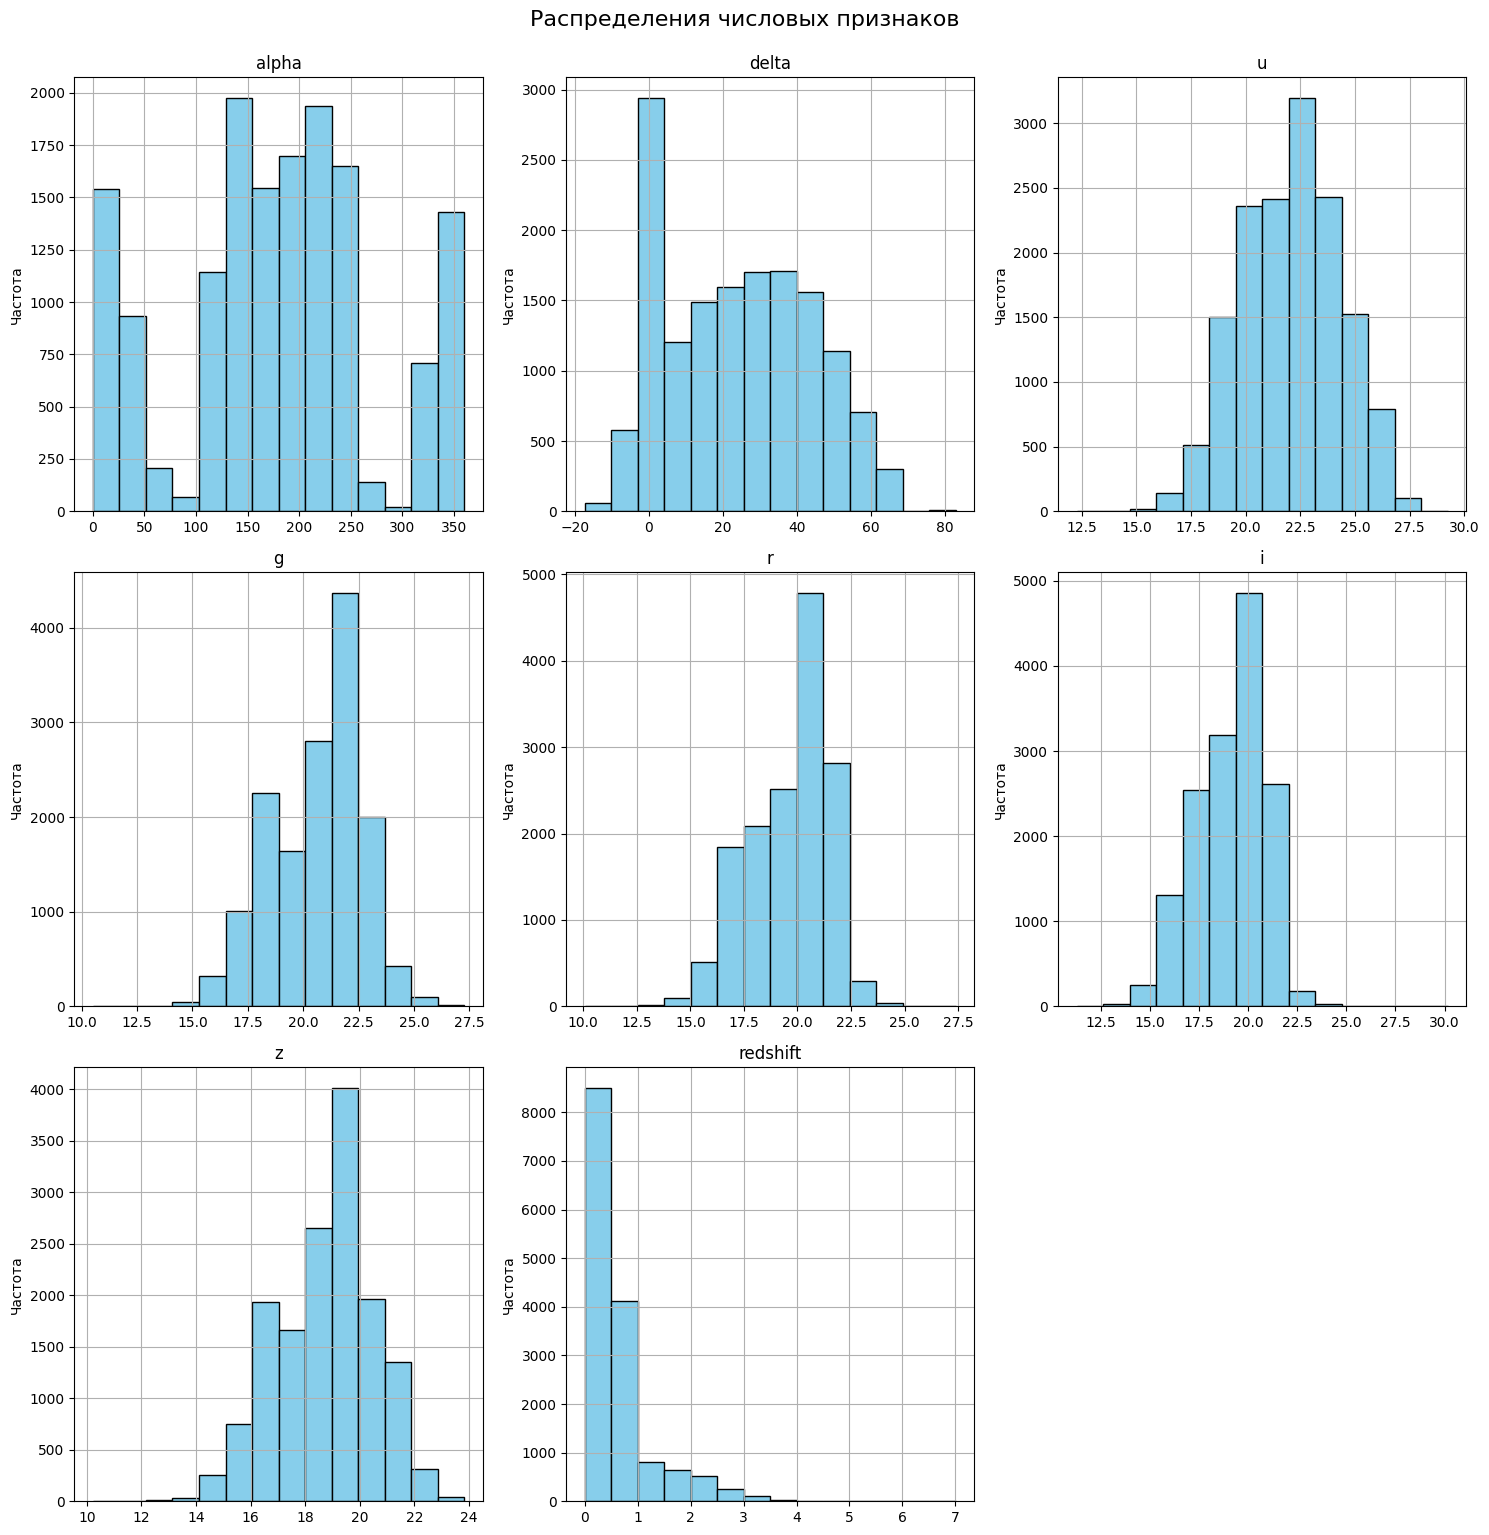

In [134]:
count_intervals = int(1 + math.log2(df.shape[0]))

n_features = len(numeric_columns)
n_subplot_cols = 3
n_subplot_rows = math.ceil(n_features / n_subplot_cols)  
fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(15, 5 * n_subplot_rows))
axes = axes.flatten() if n_subplot_rows > 1 else axes  
for i, col in enumerate(numeric_columns):
    df[col].hist(bins=count_intervals, ax=axes[i], 
                 color='skyblue', edgecolor='black')
    axes[i].set_title(col)  
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

4. Анализ признаков и выбросов

Анализ выбросов: <br>
Наиболее выраженные выбросы наблюдаются в признаке redshift. Остальные признаки (alpha, delta, u, g, r, i, z) имеют более или менее умеренное распределение с небольшими хвостами.

Анализ признаков:<br>

1. redshift — имеет выбросы. <br>
Статистика:<br>
Минимум: -0.004255 (очень близко к 0)<br>
Максимум: 7.011245 — большое значение.<br>
Среднее: 0.573, медиана: 0.418 — значит, среднее смещено вправо из-за "хвоста".<br>
Стандартное отклонение: 0.726 — довольно большое относительно среднего.<br>
Асимметрия: 2.489 — сильная правосторонняя асимметрия. Это говорит о длинном правом хвосте — именно там находятся выбросы.<br>
Эксцесс: 9.719 — очень высокий. Это указывает на то, что распределение имеет тяжёлые хвосты и много значений, отдалённых от центра (выбросов).<br>
Гистограмма: подавляющее большинство объектов имеют redshift близкий к 0 (от 0 до 1), а затем идут редкие объекты с redshift > 2, и один-два с redshift > 6.<br>
Для задачи кластеризации необработанные данные с такими выбросами могут доминировать и искажать результаты, если не обработать.<br>

2. Фотометрические признаки (u, g, r, i, z) <br>
Статистика: Все имеют примерно одинаковый диапазон (около 10–30), средние значения около 19–22, стандартное отклонение около 1.8–2.2.<br>
Асимметрия: Отрицательная (от -0.077 до -0.519), что означает левостороннюю асимметрию — небольшой "хвост" слева (меньшие значения). Это соответствует гистограммам, где пик смещен вправо.<br>
Эксцесс: Близок к 0 или немного отрицательный — распределения близки к нормальным или слегка плосковершинным.<br>
Гистограммы: Распределения достаточно симметричны, с небольшими хвостами слева (особенно заметно в g, r, i). Есть несколько значений в левом хвосте, которые можно считать потенциальными выбросами, но они не так экстремальны, как в redshift.<br>
То есть, небольшие выбросы слева имеются, но они не являются критичными.<br> 

3. Координаты (alpha, delta)<br>
Статистика:<br>
alpha: от 0 до 360, среднее 178, стандартное отклонение 97 — это широкое распределение, но оно ожидаемо для данных, покрывающих всю небесную сферу.<br>
delta: от -17 до 83, среднее 24, стандартное отклонение 19 — также ожидаемо для сканирования SDSS.<br>
Асимметрия: Почти нулевая для alpha, небольшая положительная для delta — распределения почти симметричны.<br>
Эксцесс: Отрицательный — распределения плосковершинные, что часто бывает при равномерном распределении по сфере.<br>
Гистограммы: Распределения выглядят равномерными или слегка неравномерными, без явных выбросов.<br>
Вывод: Выбросов нет. Эти признаки описывают положение объектов на небе, и их распределение естественно широкое.

5. Обработка признака redshift (имеет выбросы)

Применяем логарифмирование:
y = ln(1+x)

count    15000.000000
mean         0.376774
std          0.365513
min         -0.004264
25%          0.049358
50%          0.349517
75%          0.531830
max          2.080846
Name: redshift_log, dtype: float64
Асимметрия:    1.096
Эксцесс:    0.933
Мода: 0.0


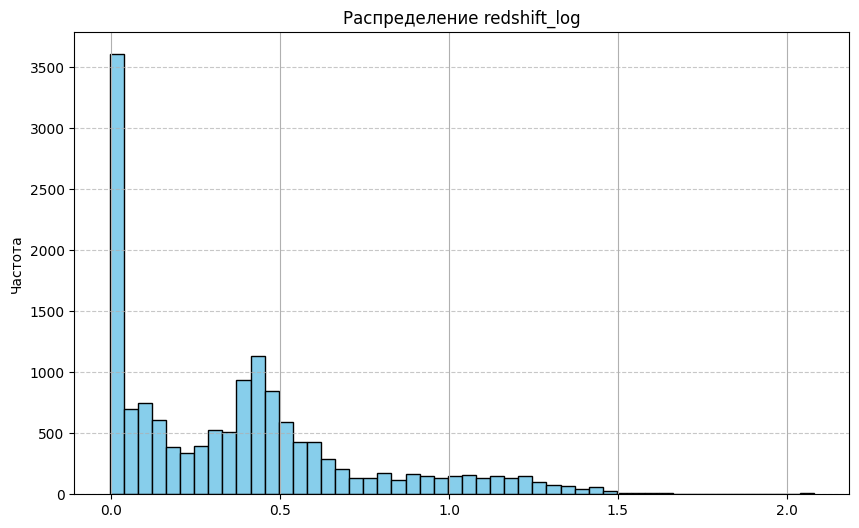

In [135]:
df['redshift_log'] = np.log1p(df['redshift'])
columns_to_drop = ['redshift']
df = df.drop(columns=columns_to_drop)

print(df['redshift_log'].describe())

skew_val = skew(df['redshift_log'].dropna())
print(f"Асимметрия: {skew_val:8.3f}")
kurt_val = kurtosis(df['redshift_log'].dropna())
print(f"Эксцесс: {kurt_val:8.3f}")
mode_value = df['redshift_log'].mode()
print(f"Мода: {mode_value.iloc[0]}")

df['redshift_log'].hist(bins=50, figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Распределение redshift_log')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

Анализ признака redshift после обработки:<br>

Максимум: 2.08 — значительно меньше, чем 7.01. Это означает, что логарифмирование успешно "сжало" правый хвост. <br>
Асимметрия: 1.096 — уменьшилась более чем вдвое. Распределение стало гораздо менее асимметричным, хотя всё ещё имеет небольшой правосторонний хвост.<br>
Эксцесс: 0.933 — резко уменьшился (было 9.7). Теперь распределение близко к нормальному (экссцесс нормального распределения = 0). Это говорит о том, что "тяжёлые хвосты" почти исчезли.<br>
Гистограмма: Пик около 0 стал ещё более выраженным, но теперь есть заметное возвышение вокруг 0.5–0.6, и хвост идёт плавно до 2.08, без резких скачков или экстремальных значений. Это гораздо более приемлемо для кластеризации распределение.<br>

Логарифмирование (log(1 + redshift)) очень эффективно смягчило влияние выбросов в признаке redshift. Максимальное значение снизилось до 2.08, что делает его сравнимым по масштабу с другими признаками (например, alpha, delta). Сильная правосторонняя асимметрия уменьшилась до умеренной. Эксцесс упал с 9.7 до 0.93, что говорит о том, что распределение стало гораздо ближе к нормальному.

6. Стандартизация числовых признаков

Формула стандартизации: <br>
z = (x - μ) / σ, где <br>
x - исходное значение <br>
μ - среднее значение признака <br>
σ - стандартное отклонение признака <br>
z - стандартизированное значение <br>

Хотя распределения большинства числовых признаков (кроме redshift) не являются строго нормальными, они демонстрируют умеренную асимметрию и отсутствие экстремальных выбросов. После предварительной обработки (логарифмирования) признака redshift его распределение стало значительно более симметричным и приближённым к нормальному. Учитывая, что алгоритмы кластеризации чувствительны к масштабу признаков, а StandardScaler эффективен при умеренных отклонениях от нормальности, выбор StandardScaler является обоснованным. 

In [136]:
df_scaled = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

7. Матрица диаграмм рассеивания

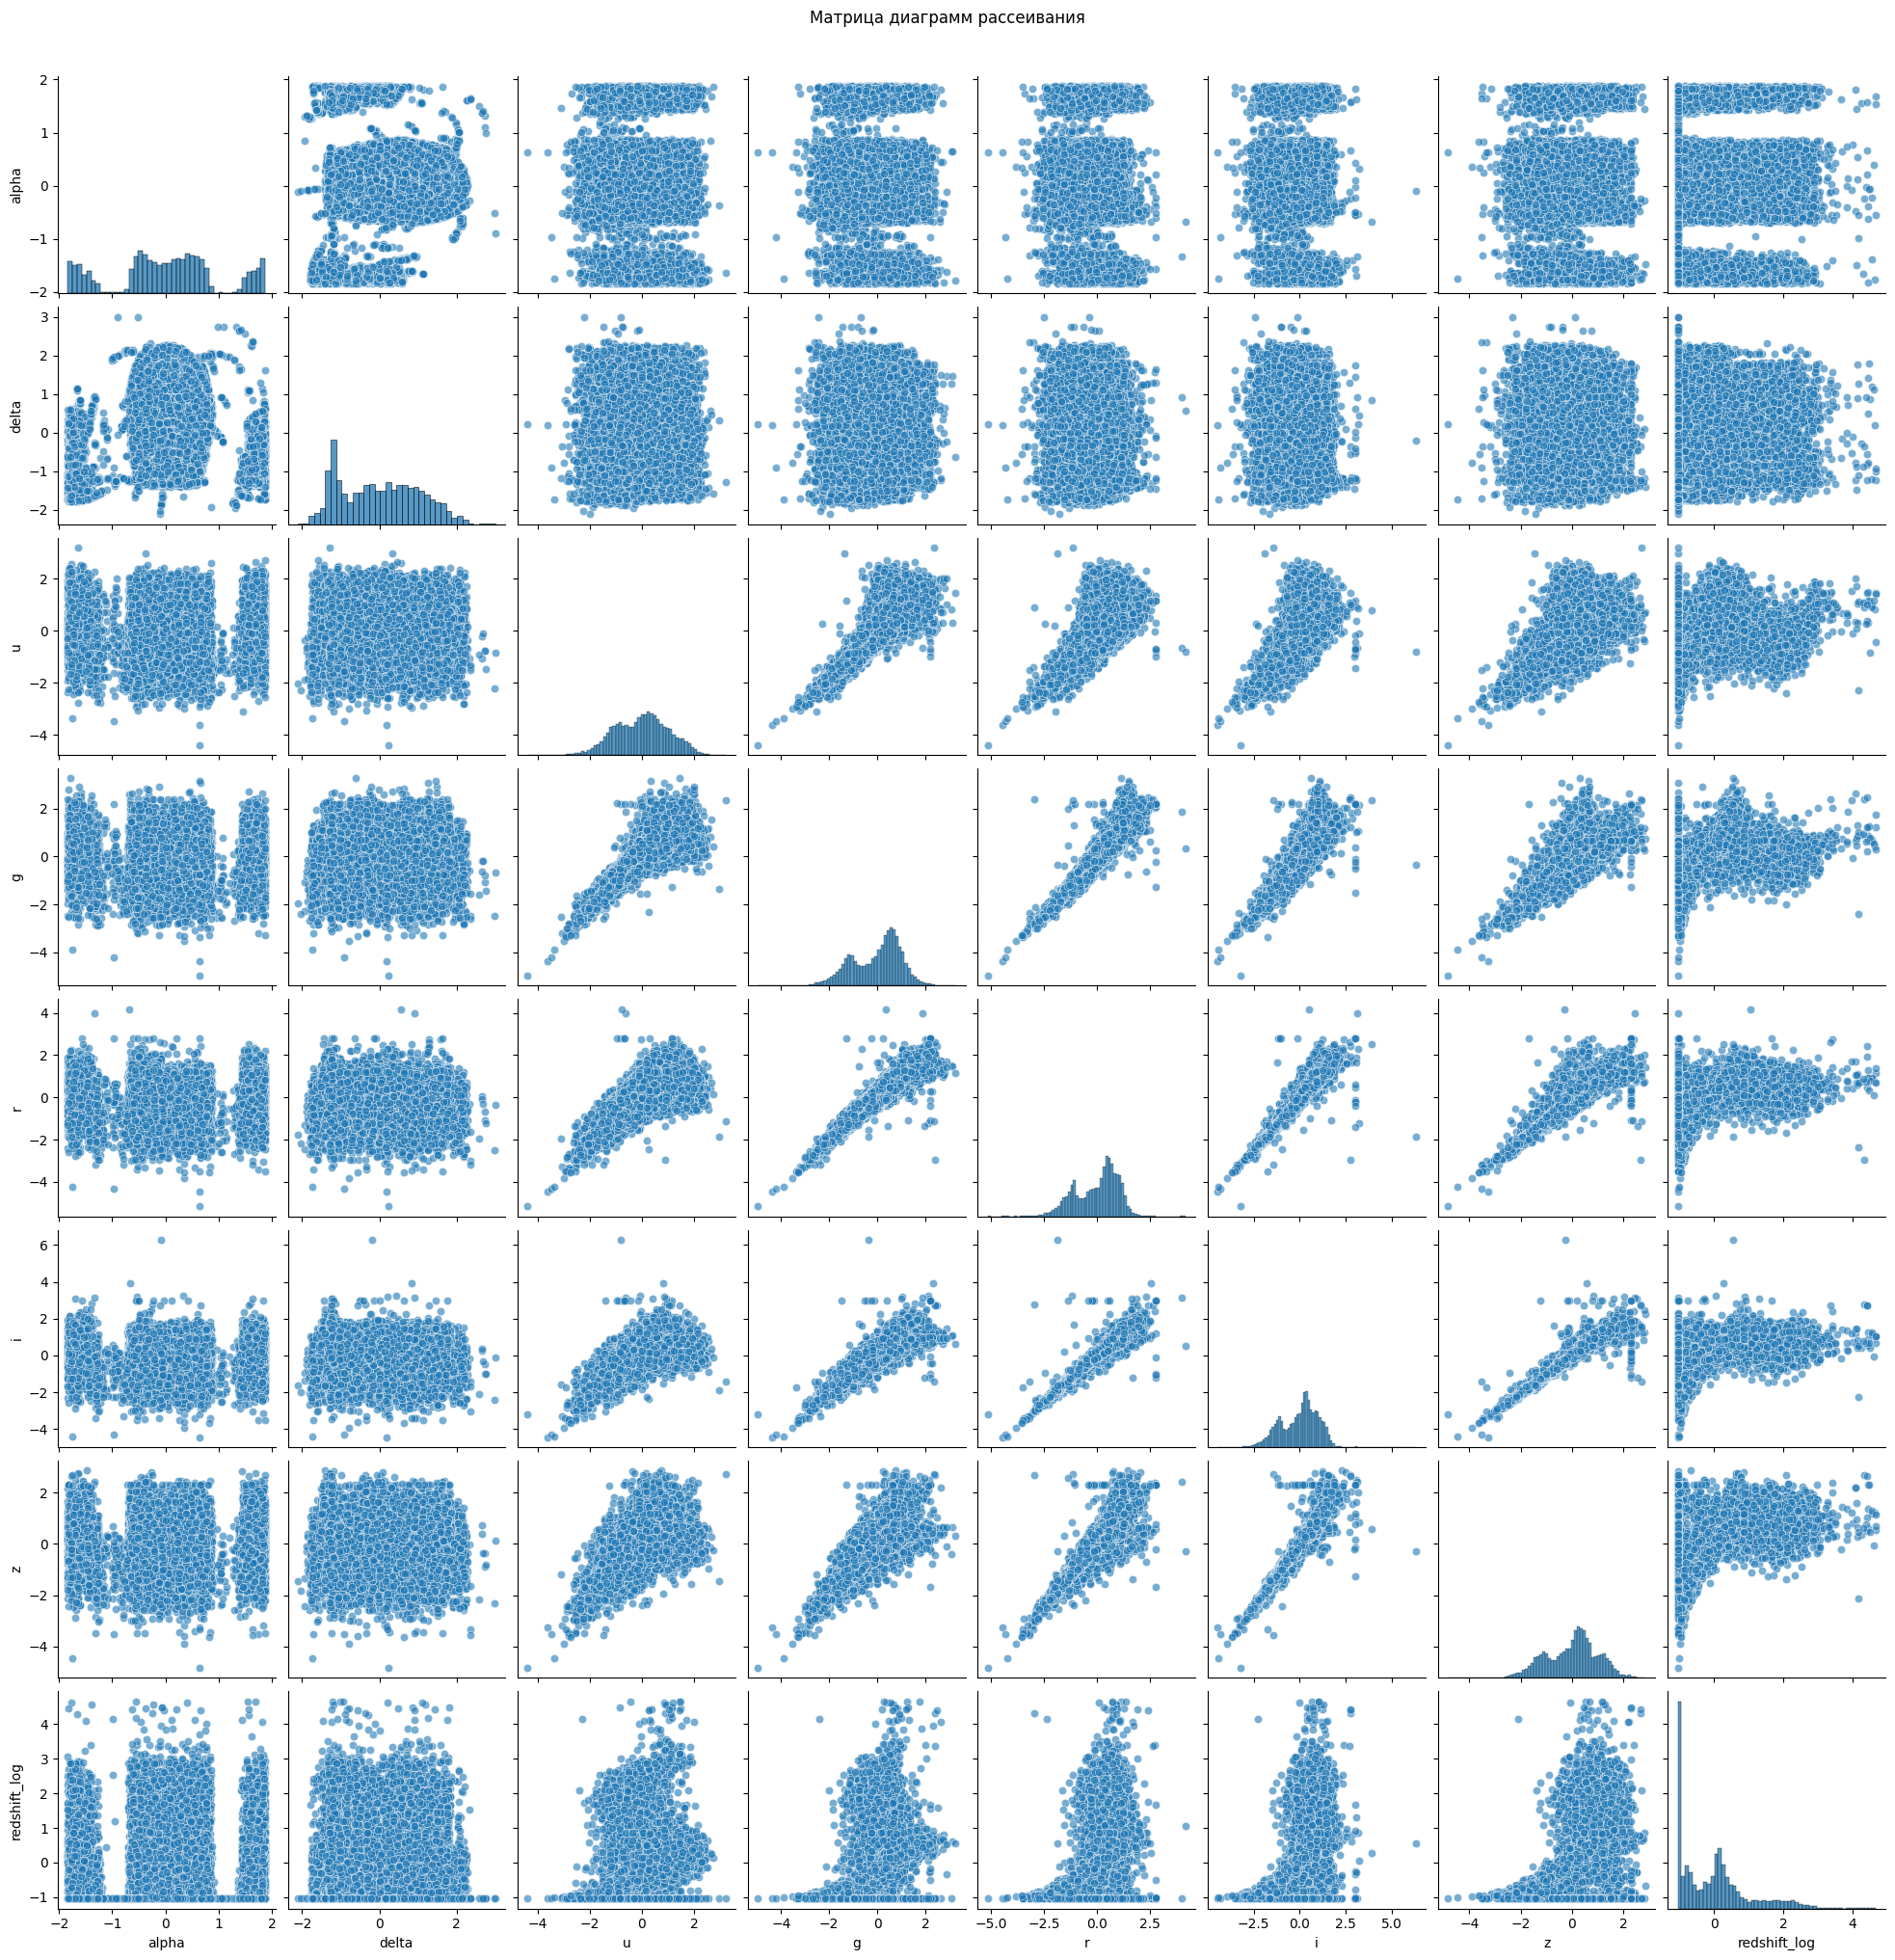

In [137]:
sns.pairplot(df_scaled, diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle("Матрица диаграмм рассеивания", y=1.02)
plt.show()

Признаки alpha и delta: <br>
Диаграммы с другими признаками (u, g, r, i, z, redshift_log) — нет чётких групп, точки распределены равномерно по плоскости. То есть, признаки alpha и delta не несут информации о кластерах — они просто описывают положение объекта на небе, а не его физические свойства.

Фотометрические признаки (u, g, r, i, z): <br>
Диаграммы между собой (например, g и r, r и i, i и z) — чётко видны линейные зависимости: точки образуют вытянутые "облака" вдоль диагонали. Это говорит о том, что признаки сильно коррелированы — например, чем ярче объект в полосе g, тем ярче он и в r, i, z. Это ожидаемо, так как фотометрические данные отражают цветовые индексы, которые связаны между собой. 

Признак redshift_log (логарифмированный redshift):<br>
Диаграммы с фотометрическими признаками (u, g, r, i, z) — видна чёткая зависимость: чем выше redshift_log, тем меньше значение в u, g, r, i, z — то есть, объекты с большим красным смещением кажутся тусклее. На графиках точки образуют "облако", которое вытянуто в направлении вниз-вправо.

Визуальный анализ матрицы диаграмм рассеивания показал, что данные не имеют чётко выраженных изолированных кластеров, а представляют собой единое «облако» точек с плавным градиентом. Наиболее значимым признаком для разделения является redshift_log: чем он выше, тем ниже значения фотометрических признаков (u, g, r, i, z). Это позволяет предположить, что объекты могут быть условно разделены на 2–3 группы по величине красного смещения — близкие, средние и далёкие объекты.

8. Метод K-means (K-средних) <br>

В основе работы K-means лежит принцип минимизации расстояния между объектами внутри одного кластера.

Основные этапы работы алгоритма:
- инициализация центроидов. Алгоритм случайным образом выбирает k начальных точек, называемых центроидами. Эти точки служат временными центрами кластеров.

- назначение объектов кластерам. Каждый объект в наборе данных назначается к кластеру, центроид которого находится ближе всего. Для расчета расстояния обычно используют евклидову метрику, но есть и другие меры сходства, например косинусное расстояние или расстояние Манхэттена.

- обновление центроидов. После назначения объектов кластерам вычисляют новые центроиды. Каждый центроид перемещается в среднюю точку всех объектов, принадлежащих его кластеру.

- повторение. Предыдущие шаги повторяют до тех пор, пока центроиды не перестанут значительно изменяться, что свидетельствует о достижении сходимости. 

Определение оптимального значения k с использованием метода локтя и анализа силуэта.

Метод локтя: <br>
выполняется кластеризация для различных значений k и строится график зависимости суммарной внутрикластерной дисперсии от количества кластеров. Внутрикластерная дисперсия (или сумма квадратов расстояний между объектами и их центроидом) показывает, насколько компактными являются кластеры. Чем меньше внутрикластерная дисперсия, тем более «упорядочены» и «однородны» кластеры.
Точка на графике, где происходит значительное снижение дисперсии, а затем снижение становится менее заметным, называется локтем. Это и есть оптимальное количество кластеров.

Метод анализа силуэта: <br>
силуэт кластера — метод графического представления результатов кластеризации, с помощью которого можно визуально оценить качество построенной кластерной модели. В основе идеи метода лежит вычисление коэффициентов кластерных силуэтов. На диаграмме для каждого объекта коэффициент силуэта отображается прямоугольником соответствующей длины. Прямоугольники группируются по кластерам (которые обычно выделяются цветом). Таким образом, на диаграмме становится виден «силуэт» каждого кластера, откуда и название метода. По форме силуэтов аналитик оперативно может оценить качество кластеризации. Чем форма силуэтов ближе к прямоугольной, а площадь (средний коэффициент силуэта) ближе к 1, тем лучше кластеризация. Напротив, чем больше в кластере объектов с низким коэффициентом силуэта, которые порождают «узкие» силуэты, тем хуже кластеризация.

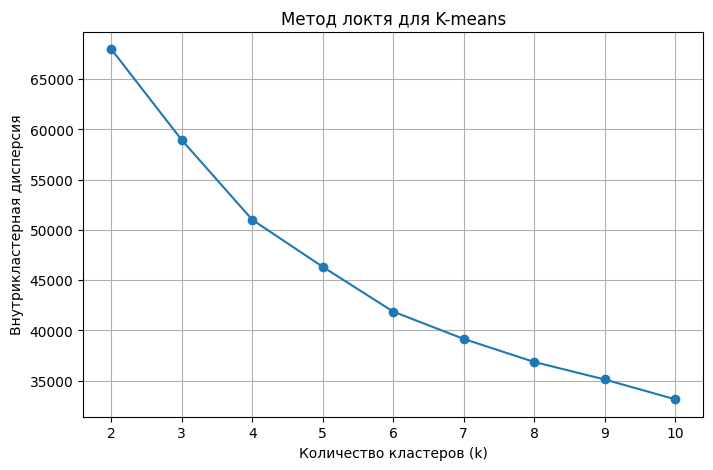

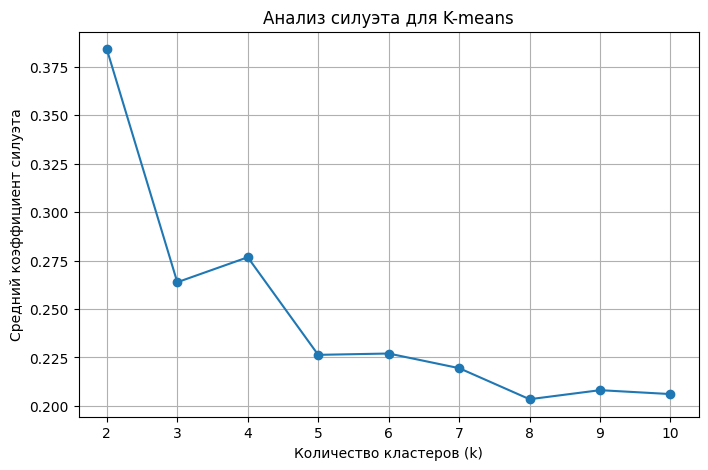

Оптимальное количество кластеров по силуэту: 2


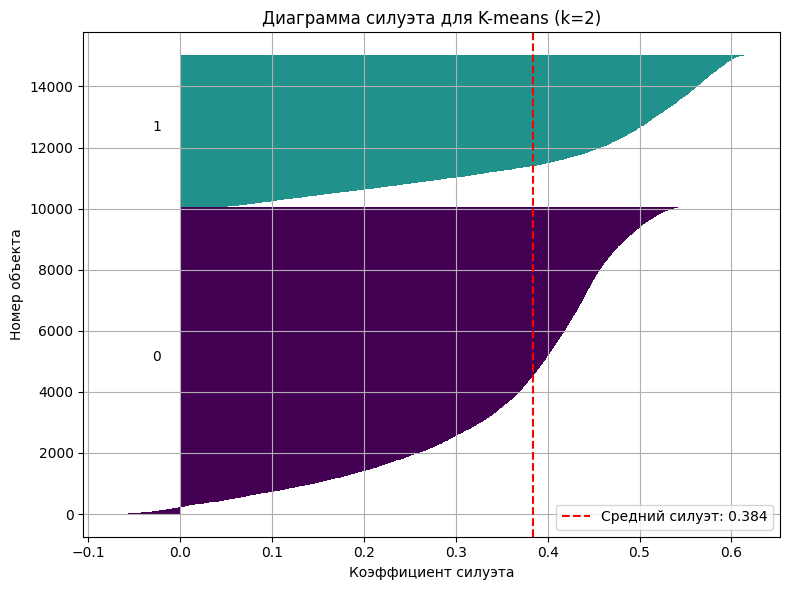

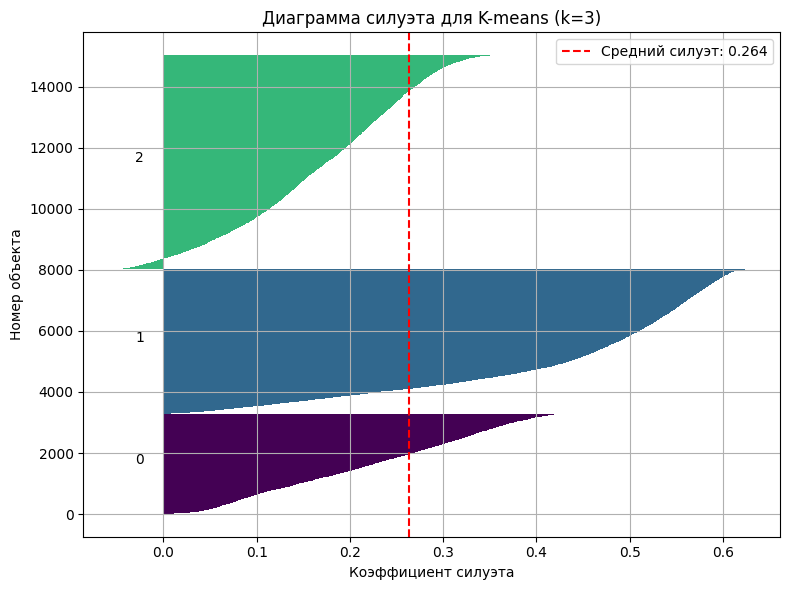

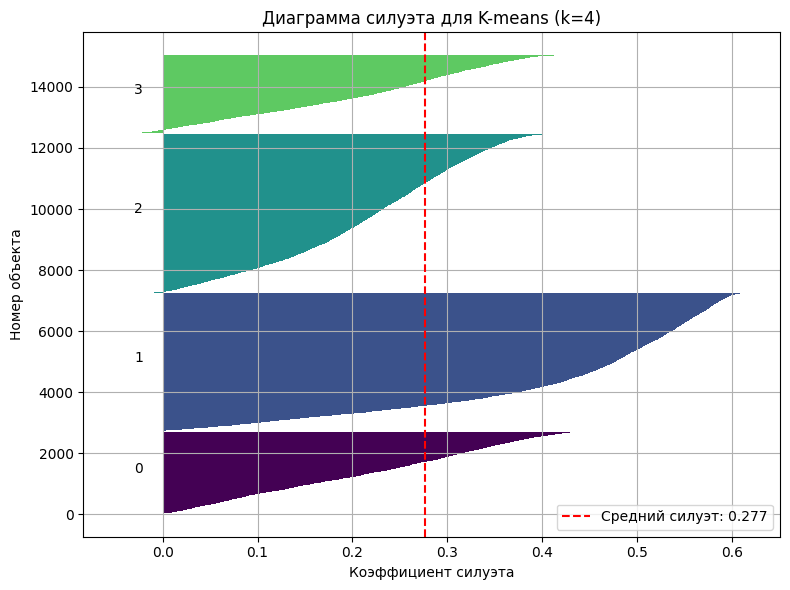

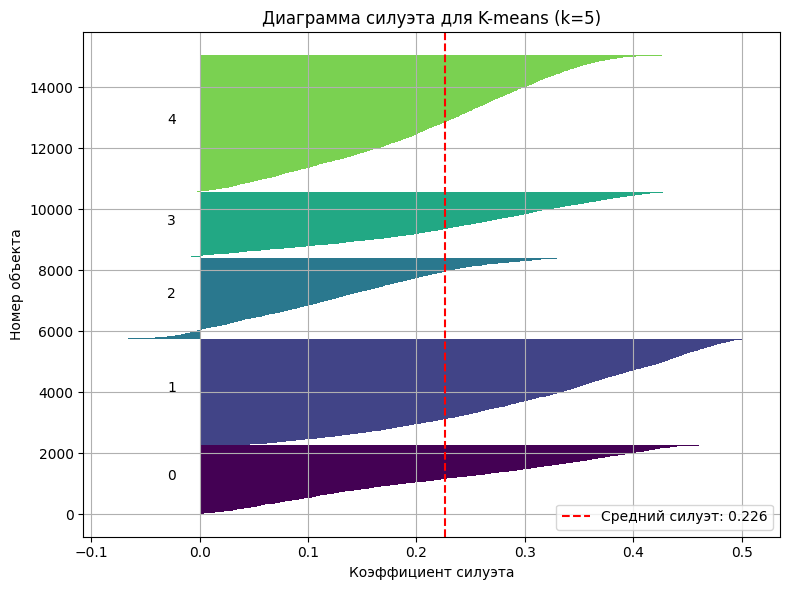

In [ ]:
k_range = range(2, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Метод локтя для K-means")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Внутрикластерная дисперсия")
plt.grid()
plt.show()


silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Анализ силуэта для K-means")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Средний коэффициент силуэта")
plt.grid()
plt.show()

best_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное количество кластеров по силуэту: {best_k}")


k_range = range(2, 6) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)

    silhouette_vals = silhouette_samples(df_scaled, cluster_labels)

    y_lower = 10
    plt.figure(figsize=(8, 6))

    for i in range(k):  
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort() 
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.viridis(float(i) / k)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals,
                 height=1.0, edgecolor='none', color=color)

        plt.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    avg_silhouette = silhouette_score(df_scaled, cluster_labels)
    plt.axvline(x=avg_silhouette, color="red", linestyle="--", label=f"Средний силуэт: {avg_silhouette:.3f}")

    plt.xlabel("Коэффициент силуэта")
    plt.ylabel("Номер объекта")
    plt.title(f"Диаграмма силуэта для K-means (k={k})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Метод локтя: <br>
Метод локтя не показал чётко выраженного излома — кривая инерции плавно убывает с увеличением количества кластеров. Это может свидетельствовать о том, что данные не имеют чётко выраженной структуры с изолированными кластерами. Однако, минимальное ускорение уменьшения инерции наблюдается при k=2, что поддерживает выбор k=2.

Анализ силуэта:<br>
Максимум силуэта — при k=2 (коэффициент примерно 0.38). При k=3 — резкое падение (около 0.26), затем небольшой рост до k=4 (где-то 0.28), но потом снова снижение. Это говорит о том, что при k=2 кластеры наиболее "плотные" и хорошо разделённые. <br>

Диаграммы силуэтов подтверждают это: при k=2 кластеры имеют наиболее широкие и плотные "силуэты", что указывает на хорошее качество кластеризации. При увеличении k до 3 и более, силуэты становятся уже и неравномернее, а средний коэффициент силуэта снижается.

Таким образом, для метода K-means (K-средних) будет использоваться  k=2.

9. Реализация метода K-means (K-средних) при k=2 (k - количество кластеров)

Метрики: <br>

Центры кластеров в алгоритме кластеризации называют центроидами. Эти точки служат временными центрами кластеров.  <br>

Внутрикластерное расстояние — это среднее расстояние между объектами внутри одного кластера. Чем меньше это расстояние, тем кластер плотнее. <br>

Компактность кластеров можно оценить с помощью внутрикластерной дисперсии (суммы квадратов расстояний между объектами и их центроидом). Чем меньше внутрикластерная дисперсия, тем более «упорядочены» и «однородны» кластеры. <br>

Расстояние между кластерами (межкластерное расстояние) — это расстояние между разными кластерами. Хорошая кластеризация означает большие межкластерные расстояния и хорошо разделённые кластеры. 

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(df_scaled)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

centers = kmeans.cluster_centers_

intra_distances = []
for i in range(kmeans.n_clusters):
    mask = cluster_labels_kmeans == i
    cluster_points = df_scaled.values[mask]
    center = centers[i].reshape(1, -1)
    distances = euclidean_distances(cluster_points, center).flatten()
    intra_distances.append(distances.mean())

inertias_per_cluster = []
for i in range(kmeans.n_clusters):
    mask = cluster_labels_kmeans == i
    cluster_points = df_scaled.values[mask]
    center = centers[i].reshape(1, -1)
    distances_sq = ((cluster_points - center)**2).sum(axis=1)
    inertias_per_cluster.append(distances_sq.sum())

inter_distances = euclidean_distances(centers)


centers_df = pd.DataFrame(centers, 
                          columns=df_scaled.columns, 
                          index=[f'Кластер {i}' for i in range(len(centers))])
print("Центр кластеров:")
print(centers_df)
print()

intra_df = pd.DataFrame({
    'Кластер': [f'Кластер {i}' for i in range(len(intra_distances))],
    'Среднее внутрикластерное расстояние': intra_distances
})
print("Средние внутрикластерные расстояния:")
print(intra_df)
print()

compactness_df = pd.DataFrame({
    'Кластер': [f'Кластер {i}' for i in range(len(inertias_per_cluster))],
    'Суммарная компактность (инерция)': inertias_per_cluster
})
print("Компактность кластеров:")
print(compactness_df)
print()

inter_df = pd.DataFrame(inter_distances,
                        index=[f'Кластер {i}' for i in range(len(centers))],
                        columns=[f'Кластер {i}' for i in range(len(centers))])
print("Матрица расстояний между центрами кластеров:")
print(inter_df)

Центр кластеров:
              alpha     delta         u         g         r         i  \
Кластер 0  0.001165  0.018003  0.496706  0.584492  0.595747  0.573546   
Кластер 1 -0.002359 -0.036453 -1.005732 -1.183481 -1.206270 -1.161318   

                  z  redshift_log  
Кластер 0  0.549918       0.37097  
Кластер 1 -1.113475      -0.75114  

Средние внутрикластерные расстояния:
     Кластер  Среднее внутрикластерное расстояние
0  Кластер 0                             2.115212
1  Кластер 1                             1.804098

Компактность кластеров:
     Кластер  Суммарная компактность (инерция)
0  Кластер 0                      48934.926564
1  Кластер 1                      19050.488820

Матрица расстояний между центрами кластеров:
           Кластер 0  Кластер 1
Кластер 0   0.000000   3.958416
Кластер 1   3.958416   0.000000


Центры кластеров: <br>
Кластер 0:<br>
redshift_log = 0.371 - положительное значение, что соответствует реальному красному смещению (увеличение длины волны). Это указывает на объекты, находящиеся на относительно близком расстоянии (меньшее красное смещение).
Фотометрические признаки (u, g, r, i, z) — положительные значения => объекты кажутся ярче или имеют цветовые характеристики, близкие к средним. Координаты (alpha, delta) близки к нулю, что говорит о среднем положении на небесной сфере. <br>

Кластер 1:<br>
redshift_log = -0.751 - объекты находятся очень далеко и сильно смещены в красную область спектра.
Фотометрические признаки — отрицательные => менее яркие или смещённые в инфракрасную область. <br>

Первый кластер объединяет объекты с умеренным красным смещением и средними координатами (прямое восхождение и склонение), что соответствует близким или умеренно удалённым объектам. Второй кластер содержит объекты с высоким красным смещением, расположенными в другой области небесной сферы и имеющими более тусклый или смещённый в инфракрасный диапазон спектр. Это позволяет интерпретировать кластеры как группы объектов, различающиеся по расстоянию, положению на небе и физическим характеристикам. <br>


Средние внутрикластерные расстояния: <br>
Кластер 0: среднее расстояние до центра — 2.115 => менее плотный, но всё ещё устойчивый.<br>
Кластер 1: среднее расстояние — 1.804 => немного плотнее, чем Кластер 0. Разница небольшая (около 0.31), что говорит о сравнимой плотности. <br>
Оба кластера достаточно плотные, разница между ними минимальна. <br>

Компактность кластеров: <br>
Кластер 0: 48934.93 — значительно больше, чем у Кластера 1. <br>
Кластер 1: 19050.49 — меньше, что может говорить о меньшем размере или большей плотности. Однако, среднее внутрикластерное расстояние у Кластера 0 только немного больше, чем у Кластера 1, что говорит о том, что Кластер 0 содержит больше точек.<br>
Кластер 0 больше по размеру, Кластер 1 — плотнее, но оба кластера стабильны. <br>

Матрица расстояний между центрами кластеров: <br>
Расстояние между центрами: 3.958 - хорошая разделимость. Кластеры хорошо отделены друг от друга, не пересекаются. Разделение кластеров чёткое, качество кластеризации высокое.

10. Метод DBSCAN <br>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — алгоритм кластеризации, основанный на концепции плотности точек данных в пространстве. <br>
Параметры метода: <br>
- ε (eps) - определяет радиус окрестности вокруг точки данных, все точки в пределах этого расстояния считаются соседними.
- min_samples - минимальное количество точек данных (включая саму точку), необходимое для формирования плотного региона или кластера.

Основная идея: точки, окружённые областями высокой плотности, объединяются в один кластер. При этом выделяются следующие типы точек: 
- Core points (ключевые точки) — в их окрестности находится минимальное количество соседних точек (min_samples) на расстоянии не более ε (эпсилон).
- Border points (граничные точки) — находятся на границе кластера, имея меньше min_samples соседей в радиусе ε, но при этом достижимы из ключевых точек.
- Noise points (шумовые точки) — изолированные точки, не подходящие под определение ключевых или граничных.

In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples=20)
cluster_labels_dbscan = dbscan.fit_predict(df_scaled)

n_clusters = len(set(cluster_labels_dbscan)) - (1 if -1 in cluster_labels_dbscan else 0)
n_noise = list(cluster_labels_dbscan).count(-1)

print(f"DBSCAN: найдено кластеров: {n_clusters}, шумовых точек: {n_noise}")


DBSCAN: найдено кластеров: 2, шумовых точек: 1931


Метрики: <br>
DBSCAN — алгоритм плотностной кластеризации, он не опирается на центры, как K-means. Поэтому "центры" — это условные величины, не отражающие внутреннюю логику DBSCAN (центры классов это средние значения
точек в кластере (псевдоцентры)). Компактность и внутрикластерные расстояния — тоже условные, но показывают плотность кластера (внутриклассовые расстояния - расстояния от точек до псевдоцентра, компактность - сумма квадратов расстояний до псевдоцентра). Соответственно расстояние между центрами это расстояния между
псевдоцентрами кластеров. 

Исходные метрики не являются частью логики DBSCAN, но позволяют количественно оценить структуру выделенных кластеров и провести сравнительный анализ.

In [ ]:
mask_non_noise = cluster_labels_dbscan != -1
df_scaled_non_noise = df_scaled.values[mask_non_noise]
labels_non_noise = cluster_labels_dbscan[mask_non_noise]

unique_labels = set(labels_non_noise)

centers_dbscan = []
for label in unique_labels:
    mask = labels_non_noise == label
    cluster_points = df_scaled_non_noise[mask]
    center = cluster_points.mean(axis=0)
    centers_dbscan.append(center)

centers_dbscan = np.array(centers_dbscan)

centers_df_dbscan = pd.DataFrame(centers_dbscan,
                                 columns=df_scaled.columns,
                                 index=[f'Кластер {i}' for i in unique_labels])
print("Центры кластеров (DBSCAN):")
print(centers_df_dbscan)
print()

intra_distances_dbscan = []
for label in unique_labels:
    mask = labels_non_noise == label
    cluster_points = df_scaled_non_noise[mask]
    center = centers_dbscan[label].reshape(1, -1)
    distances = euclidean_distances(cluster_points, center).flatten()
    intra_distances_dbscan.append(distances.mean())

intra_df_dbscan = pd.DataFrame({
    'Кластер': [f'Кластер {i}' for i in unique_labels],
    'Среднее внутрикластерное расстояние': intra_distances_dbscan
})
print("Средние внутрикластерные расстояния (DBSCAN):")
print(intra_df_dbscan)
print()


inertias_dbscan = []
for label in unique_labels:
    mask = labels_non_noise == label
    cluster_points = df_scaled_non_noise[mask]
    center = centers_dbscan[label].reshape(1, -1)
    distances_sq = ((cluster_points - center)**2).sum(axis=1)
    inertias_dbscan.append(distances_sq.sum())

compactness_df_dbscan = pd.DataFrame({
    'Кластер': [f'Кластер {i}' for i in unique_labels],
    'Суммарная компактность (инерция)': inertias_dbscan
})
print("Компактность кластеров (DBSCAN):")
print(compactness_df_dbscan)
print()

inter_distances_dbscan = euclidean_distances(centers_dbscan)

inter_df_dbscan = pd.DataFrame(inter_distances_dbscan,
                               index=[f'Кластер {i}' for i in unique_labels],
                               columns=[f'Кластер {i}' for i in unique_labels])
print("Матрица расстояний между центрами кластеров (DBSCAN):")
print(inter_df_dbscan)

Центры кластеров (DBSCAN):
              alpha     delta         u         g         r         i  \
Кластер 0 -0.011850  0.006289 -0.036307 -0.035999 -0.049394 -0.053579   
Кластер 1  1.669239 -1.155365  0.292685  0.492867  0.970606  1.263937   

                  z  redshift_log  
Кластер 0 -0.052638     -0.023358  
Кластер 1  1.389368     -1.015261  

Средние внутрикластерные расстояния (DBSCAN):
     Кластер  Среднее внутрикластерное расстояние
0  Кластер 0                             2.597642
1  Кластер 1                             0.441700

Компактность кластеров (DBSCAN):
     Кластер  Суммарная компактность (инерция)
0  Кластер 0                       97310.46478
1  Кластер 1                           3.29241

Матрица расстояний между центрами кластеров (DBSCAN):
           Кластер 0  Кластер 1
Кластер 0   0.000000   3.225358
Кластер 1   3.225358   0.000000


Центры кластеров: <br>
Кластер 0:<br>
Значения признаков близки к 0, особенно alpha, delta, u, g, r, i, z. <br>
redshift_log = -0.023: очень низкое значение.<br>
Это объекты с минимальным redshift, близкие к "центру" признаков.

Кластер 1:<br>
alpha = 1.669, delta = -1.155 — сильно отклоняются от 0. <br>
u, g, r, i, z — положительные, высокие значения. <br>
Это объекты с высоким redshift, расположены в другой области неба, с высокой яркостью.

Средние внутрикластерные расстояния: <br>
Кластер 0: 2.598 — очень разреженный, точки далеко от "центра".<br>
Кластер 1: 0.442 — очень плотный, все точки близко к "центру".<br>
DBSCAN выделил один плотный и один разреженный кластер — нестабильная структура.<br>

Компактность кластеров: <br>
Кластер 0: 97310.46 — очень высокая, много точек или большой разброс. <br>
Кластер 1: 3.29 — крайне низкая, маленький и плотный кластер. <br>
Асимметричные кластеры — один большой и разреженный, другой — маленький и плотный. <br>

Матрица расстояний между центрами кластеров: <br>
3.225 — расстояние между "центрами" - меньше, чем у K-means (3.958), но всё ещё хорошо разделены.

11. Сравнительный анализ методов

In [ ]:
feature_names = df_scaled.columns.tolist()

kmeans_cluster_0_values = [round(centers[0][i], 3) for i in range(len(feature_names))]
kmeans_cluster_1_values = [round(centers[1][i], 3) for i in range(len(feature_names))]

dbscan_cluster_0_values = [round(centers_dbscan[0][i], 3) for i in range(len(feature_names))]
dbscan_cluster_1_values = [round(centers_dbscan[1][i], 3) for i in range(len(feature_names))]

metrics = [
    f'Центры кл. (Кл. 0, {f})' for f in feature_names
] + [
    f'Центры кл. (Кл. 1, {f})' for f in feature_names
] + [
    'Средн. внутрикласт. расстояние (Кл. 0)',
    'Средн. внутрикласт. расстояние (Кл. 1)',
    'Сумм. компактность (Кл. 0)',
    'Сумм. компактность (Кл. 1)',
    'Расстояние между центрами кл.',
    'Кол-во кластеров',
]

kmeans_values = kmeans_cluster_0_values + kmeans_cluster_1_values + [
    round(intra_distances[0], 3),
    round(intra_distances[1], 3),
    round(inertias_per_cluster[0], 3),
    round(inertias_per_cluster[1], 3),
    round(inter_distances[0, 1], 3),
    2,
]

dbscan_values = dbscan_cluster_0_values + dbscan_cluster_1_values + [
    round(intra_distances_dbscan[0], 3),
    round(intra_distances_dbscan[1], 3),
    round(inertias_dbscan[0], 3),
    round(inertias_dbscan[1], 3),
    round(inter_distances_dbscan[0, 1], 3),
    n_clusters,
]


comparison_df = pd.DataFrame({
    'Метрика': metrics,
    'K-means (k=2)': kmeans_values,
    'DBSCAN': dbscan_values
})

print("Объединённая таблица метрик K-means и DBSCAN:")
print(comparison_df)

Объединённая таблица метрик K-means и DBSCAN:
                                   Метрика  K-means (k=2)     DBSCAN
0                Центры кл. (Кл. 0, alpha)          0.001     -0.012
1                Центры кл. (Кл. 0, delta)          0.018      0.006
2                    Центры кл. (Кл. 0, u)          0.497     -0.036
3                    Центры кл. (Кл. 0, g)          0.584     -0.036
4                    Центры кл. (Кл. 0, r)          0.596     -0.049
5                    Центры кл. (Кл. 0, i)          0.574     -0.054
6                    Центры кл. (Кл. 0, z)          0.550     -0.053
7         Центры кл. (Кл. 0, redshift_log)          0.371     -0.023
8                Центры кл. (Кл. 1, alpha)         -0.002      1.669
9                Центры кл. (Кл. 1, delta)         -0.036     -1.155
10                   Центры кл. (Кл. 1, u)         -1.006      0.293
11                   Центры кл. (Кл. 1, g)         -1.183      0.493
12                   Центры кл. (Кл. 1, r)         -1.206

Сравнение K-means и DBSCAN показало, что K-means продемонстрировал более стабильные и сбалансированные кластеры: средние внутрикластерные расстояния и суммарная компактность близки. DBSCAN выделил кластеры с разной плотностью: кластер 1 крайне компактный, а кластер 0 — очень разбросанный. Расстояние между центрами кластеров у K-means больше, что указывает на лучшую разделимость. Таким образом, K-means оказался более стабильным и интерпретируемым методом.

12. Исследование влияния параметра k (количества кластеров) для K-means

In [ ]:
k_range = range(2, 6) 

for k in k_range:
    print(f"\n==================== k = {k} ====================")
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled)
    centers = kmeans.cluster_centers_

    centers_df = pd.DataFrame(centers, 
                              columns=df_scaled.columns, 
                              index=[f'Кластер {i}' for i in range(len(centers))])
    print("Центры кластеров:")
    print(centers_df.round(3))
    print()

    intra_distances = []
    for i in range(k):
        mask = cluster_labels == i
        cluster_points = df_scaled.values[mask]
        center = centers[i].reshape(1, -1)
        distances = euclidean_distances(cluster_points, center).flatten()
        intra_distances.append(distances.mean())

    intra_df = pd.DataFrame({
        'Кластер': [f'Кластер {i}' for i in range(len(intra_distances))],
        'Среднее внутрикластерное расстояние': [round(d, 3) for d in intra_distances]
    })
    print("Средние внутрикластерные расстояния:")
    print(intra_df)
    print()

    inertias_per_cluster = []
    for i in range(k):
        mask = cluster_labels == i
        cluster_points = df_scaled.values[mask]
        center = centers[i].reshape(1, -1)
        distances_sq = ((cluster_points - center)**2).sum(axis=1)
        inertias_per_cluster.append(distances_sq.sum())

    compactness_df = pd.DataFrame({
        'Кластер': [f'Кластер {i}' for i in range(len(inertias_per_cluster))],
        'Суммарная компактность (инерция)': [round(inertia, 3) for inertia in inertias_per_cluster]
    })
    print("Компактность кластеров:")
    print(compactness_df)
    print()

    inter_distances = euclidean_distances(centers)

    inter_df = pd.DataFrame(inter_distances,
                            index=[f'Кластер {i}' for i in range(len(centers))],
                            columns=[f'Кластер {i}' for i in range(len(centers))])
    print("Матрица расстояний между центрами кластеров:")
    print(inter_df.round(3))


==================== k = 2 ====================
Центры кластеров:
           alpha  delta      u      g      r      i      z  redshift_log
Кластер 0  0.001  0.018  0.497  0.584  0.596  0.574  0.550         0.371
Кластер 1 -0.002 -0.036 -1.006 -1.183 -1.206 -1.161 -1.113        -0.751

Средние внутрикластерные расстояния:
     Кластер  Среднее внутрикластерное расстояние
0  Кластер 0                                2.115
1  Кластер 1                                1.804

Компактность кластеров:
     Кластер  Суммарная компактность (инерция)
0  Кластер 0                         48934.927
1  Кластер 1                         19050.489

Матрица расстояний между центрами кластеров:
           Кластер 0  Кластер 1
Кластер 0      0.000      3.958
Кластер 1      3.958      0.000

==================== k = 3 ====================
Центры кластеров:
           alpha  delta      u      g      r      i      z  redshift_log
Кластер 0 -1.079 -0.882  0.518  0.579  0.565  0.524  0.499         0.216
Класт

Анализ метрик показывает, что с увеличением k средние внутрикластерные расстояния уменьшаются, суммарная компактность снижается, расстояния между центрами становятся разнообразнее. То есть, начиная с k=3, наблюдается избыточное разделение: кластеры становятся ближе друг к другу, а разница в компактности между ними уменьшается. Это указывает на то, что k=2 — оптимальный выбор.

13. Визуализация полученных кластеров

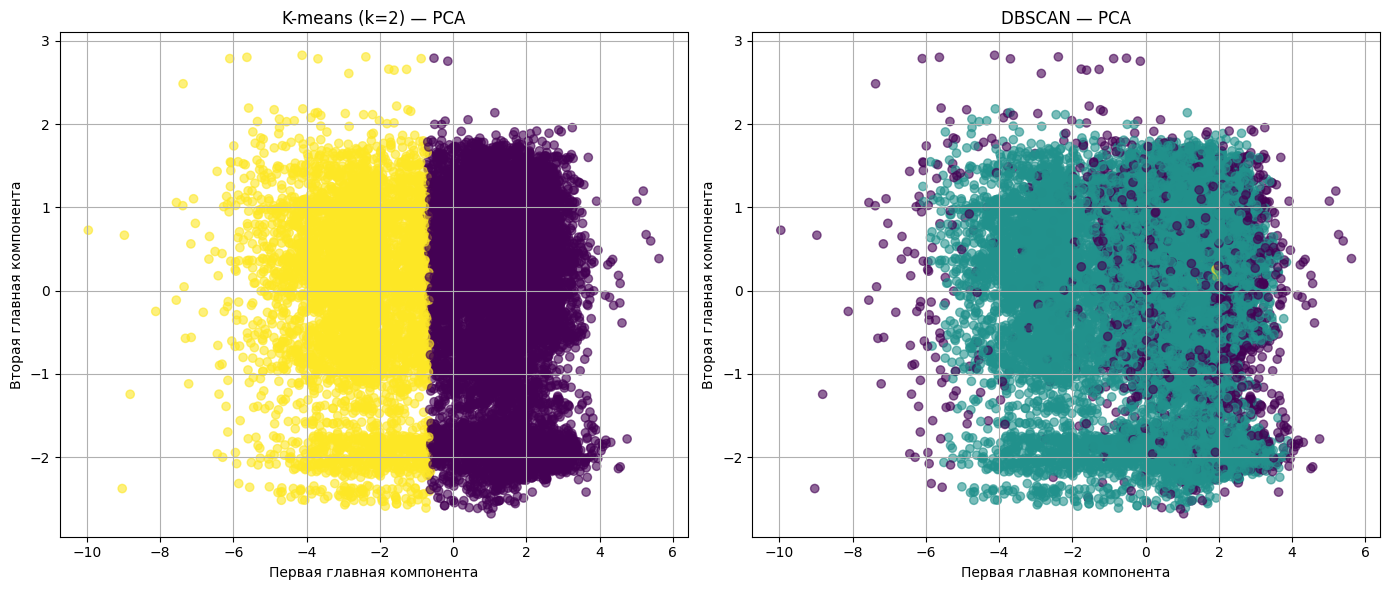

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_labels = KMeans(n_clusters=2, random_state=42).fit_predict(df_scaled)
axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0].set_title("K-means (k=2) — PCA")
axes[0].set_xlabel("Первая главная компонента")
axes[0].set_ylabel("Вторая главная компонента")
axes[0].grid()

axes[1].scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
axes[1].set_title("DBSCAN — PCA")
axes[1].set_xlabel("Первая главная компонента")
axes[1].set_ylabel("Вторая главная компонента")
axes[1].grid()

plt.tight_layout()
plt.show()

На диаграмме рассеивания, построенной с использованием PCA, видно, что K-means формирует два линейно разделимых кластера, что соответствует группировке объектов по степени красного смещения.  Кластеры в DBSCAN не имеют чёткой линейной границы — они произвольной формы, распределение более сглаженное, без резких границ, что указывает на более сложную структуру данных.

14. Вывод

В ходе лабораторной работы была выполнена задача кластеризации на основе данных из проекта SDSS (Sloan Digital Sky Survey). Числовые признаки были масштабированы с помощью StandardScaler после обработки признака redshift (логарифмирование), чтобы снизить влияние выбросов и улучшить работу алгоритмов.
Визуальный анализ показал, что данные не имеют чётко выраженных кластеров, но могут выделить 2-3 кластера по признаку красного смещения. <br>

Были реализованы два метода: K-means и DBSCAN. K-means показал стабильные и интерпретируемые кластеры. DBSCAN (с подобранными параметрами) также выделил 2 кластера, но с разной плотностью и меньшей разделимостью. K-means показал лучшее качество кластеризации и более стабильные результаты, что делает его предпочтительным методом для данной задачи.<br>

Первый кластер объединяет объекты с умеренным красным смещением и средними координатами (прямое восхождение и склонение), что соответствует близким или умеренно удалённым объектам. Второй кластер содержит объекты с высоким красным смещением, расположенными в другой области небесной сферы и имеющими более тусклый или смещённый в инфракрасный диапазон спектр. Это позволяет интерпретировать кластеры как группы объектов, различающиеся по расстоянию, положению на небе и физическим характеристикам. <br>

Анализ влияния параметра k в K-means показал, что k=2 — оптимальное значение.